In [1]:
import os, glob, re, json, math, joblib, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from pathlib import Path
from collections import Counter

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    average_precision_score, precision_recall_curve,
    confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline, FeatureUnion

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from lime.lime_text import LimeTextExplainer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPool1D

from wordcloud import WordCloud, STOPWORDS

from urllib.parse import urlparse


In [2]:
df = pd.read_csv('../data/processed/emails_combined.csv')
df.head()

,sender,receiver,date,subject,body,urls,label
0,MR. JAMES NGOLA. <james_ngola2002@maktoob.com>,webmaster@aclweb.org,2002-10-31 02:38:20+00:00,URGENT BUSINESS ASSISTANCE AND PARTNERSHIP,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...,0,1
1,Mr. Ben Suleman <bensul2004nng@spinfinder.com>,R@M,2002-10-31 05:10:00+00:00,URGENT ASSISTANCE /RELATIONSHIP (P),"Dear Friend,\n\nI am Mr. Ben Suleman a custom ...",0,1
2,PRINCE OBONG ELEME <obong_715@epatra.com>,webmaster@aclweb.org,2002-10-31 22:17:55+01:00,GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,0,1
3,PRINCE OBONG ELEME <obong_715@epatra.com>,webmaster@aclweb.org,2002-10-31 22:44:20+00:00,GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,0,1
4,Maryam Abacha <m_abacha03@www.com>,R@M,2002-11-01 01:45:04+01:00,I Need Your Assistance.,"Dear sir, \n \nIt is with a heart full of hope...",0,1


## Preprocessing

In [3]:
def preprocess_text(text):
    if pd.isna(text):  # handles NaN/None
        return ""
    text = str(text)   # handles floats/other types safely
    text = text.lower()
    text = re.sub('<.*?>', ' ', text)                            # Remove HTML tags
    text = re.sub(r'http\S+|www\S+', '', text)                   # Remove URLs
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)# Remove punctuation
    text = re.sub(r'\d+', '', text)                              # Remove numbers
    text = re.sub(r'\s+', ' ', text)                             # Normalize spaces
    return text.strip()

In [4]:
df['clean_body'] = df['body'].apply(preprocess_text)
df = df[df['clean_body'].str.strip() != '']
df.head()

,sender,receiver,date,subject,body,urls,label,clean_body
0,MR. JAMES NGOLA. <james_ngola2002@maktoob.com>,webmaster@aclweb.org,2002-10-31 02:38:20+00:00,URGENT BUSINESS ASSISTANCE AND PARTNERSHIP,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...,0,1,frommr james ngola confidential tel email jame...
1,Mr. Ben Suleman <bensul2004nng@spinfinder.com>,R@M,2002-10-31 05:10:00+00:00,URGENT ASSISTANCE /RELATIONSHIP (P),"Dear Friend,\n\nI am Mr. Ben Suleman a custom ...",0,1,dear friend i am mr ben suleman a custom offic...
2,PRINCE OBONG ELEME <obong_715@epatra.com>,webmaster@aclweb.org,2002-10-31 22:17:55+01:00,GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,0,1,from his royal majesty hrm crown ruler of elem...
3,PRINCE OBONG ELEME <obong_715@epatra.com>,webmaster@aclweb.org,2002-10-31 22:44:20+00:00,GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,0,1,from his royal majesty hrm crown ruler of elem...
4,Maryam Abacha <m_abacha03@www.com>,R@M,2002-11-01 01:45:04+01:00,I Need Your Assistance.,"Dear sir, \n \nIt is with a heart full of hope...",0,1,dear sir it is with a heart full of hope that ...


## Label Distribution

Total samples: 49844
Label distribution:
label
1    28444
0    21400
Name: count, dtype: int64


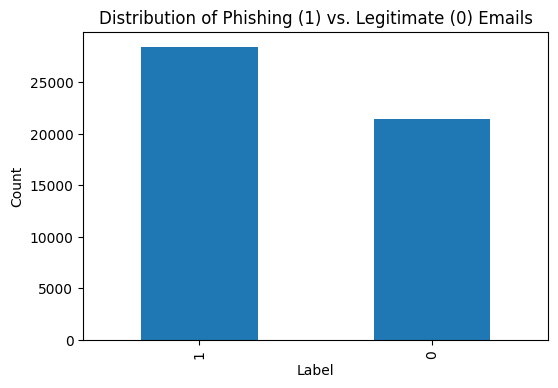

In [5]:
print(f"Total samples: {len(df)}")
print(f"Label distribution:\n{df['label'].value_counts()}")

plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar', title='Distribution of Phishing (1) vs. Legitimate (0) Emails')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

- Phishing messages still appear less frequently than legitimate mail, so downstream modeling should include imbalance handling.

## URL distribution

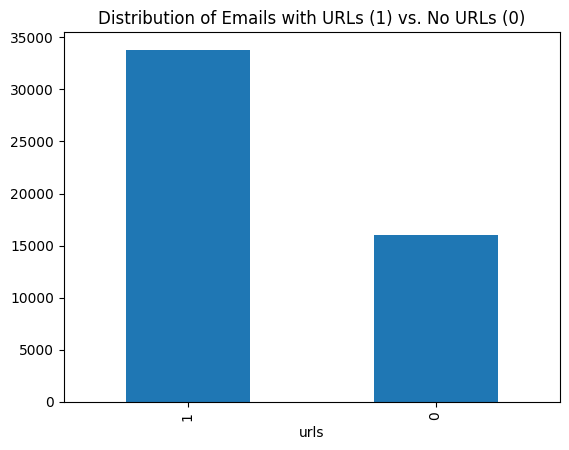

In [6]:
df['urls'].value_counts().plot(kind='bar', title='Distribution of Emails with URLs (1) vs. No URLs (0)')
plt.show()

urls
1    33797
0    16047
Name: count, dtype: int64
label          0          1
urls                       
0      40.219356  59.780644
1      44.222860  55.777140


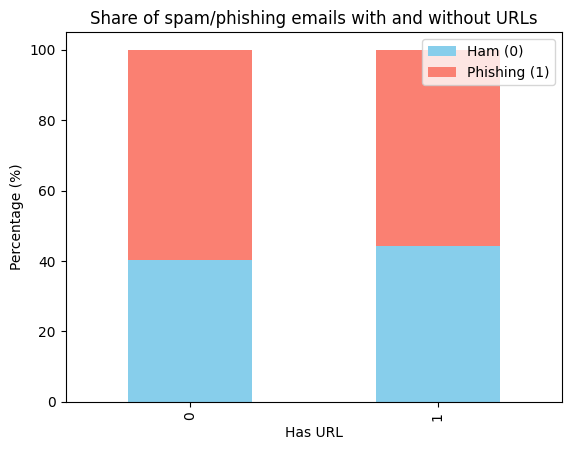

Chi²=71.02, p-value=3.541e-17


In [7]:
print(df['urls'].value_counts())

ct = pd.crosstab(df['urls'], df['label'], normalize='index') * 100
print(ct)

# Bar plot
ct.plot(kind='bar', stacked=True, color=['skyblue','salmon'])
plt.title("Share of spam/phishing emails with and without URLs")
plt.ylabel("Percentage (%)")
plt.xlabel("Has URL")
plt.legend(["Ham (0)", "Phishing (1)"])
plt.show()

from scipy.stats import chi2_contingency
tbl = pd.crosstab(df['urls'], df['label'])
chi2, p, _, _ = chi2_contingency(tbl)
print(f"Chi²={chi2:.2f}, p-value={p:.4g}")

The chart shows that both phishing and ham emails often contain URLs, though phishing remains slightly dominant in both cases.  
The chi-square test (**χ² = 71.02, p < 0.001**) confirms this association is statistically significant.

**Interpretation:**  
URL presence differs meaningfully across classes, but not decisively—legitimate emails also include many links.  
Thus, while **URL occurrence is linked to phishing**, the **type and domain of the link** will provide stronger predictive value than simple presence.


## URL word cloud


Top 20 Domains in Phishing Subjects:


,Domain,Frequency
0,iiu.taint.org,3
1,efi.ie,2
2,internationafreecall.com,2



Top 20 Domains in Ham Subjects:


,Domain,Frequency
0,apt.nixia.no,10
1,spamassassin.org,2
2,google-analytics.com,2
3,api.pownce.com,2



Top 20 Domains in Phishing Bodies:


,Domain,Frequency
0,cnn.com,67511
1,milddear.com,190
2,flapprice.com,188
3,fetessteersit.com,188
4,dearcan.com,186
5,whitedone.com,183
6,dearbright.com,178
7,placefall.com,171
8,fundspampasau.com,160
9,asterduskyhah.com,158



Top 20 Domains in Ham Bodies:


,Domain,Frequency
0,xent.com,530
1,sciencemag.org,434
2,go.techtarget.com,420
3,infoworld.com,381
4,stat.ethz.ch,374
5,radio.weblogs.com,372
6,r-project.org,365
7,newsisfree.com,352
8,e2ma.net,322
9,amazon.com,306


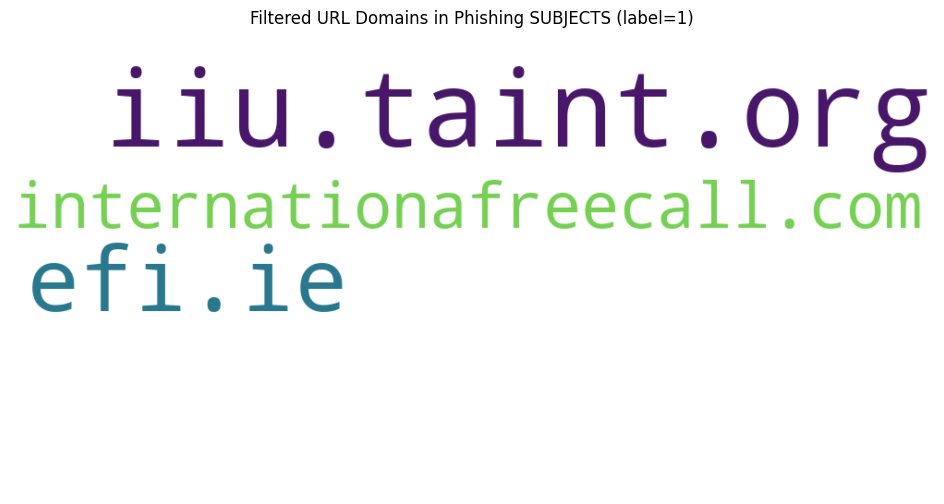

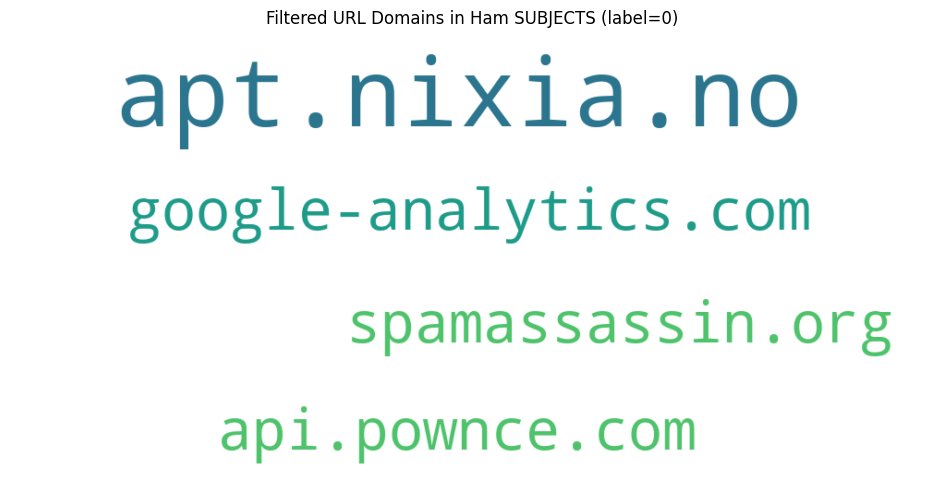

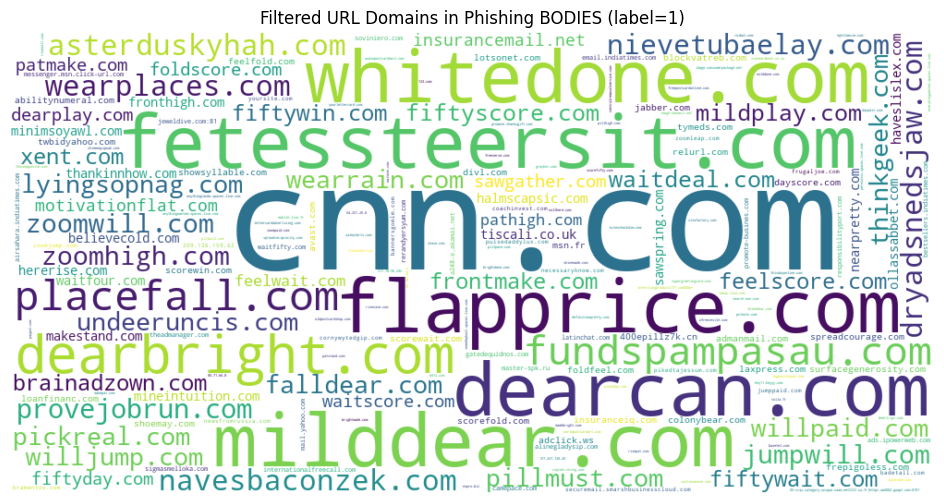

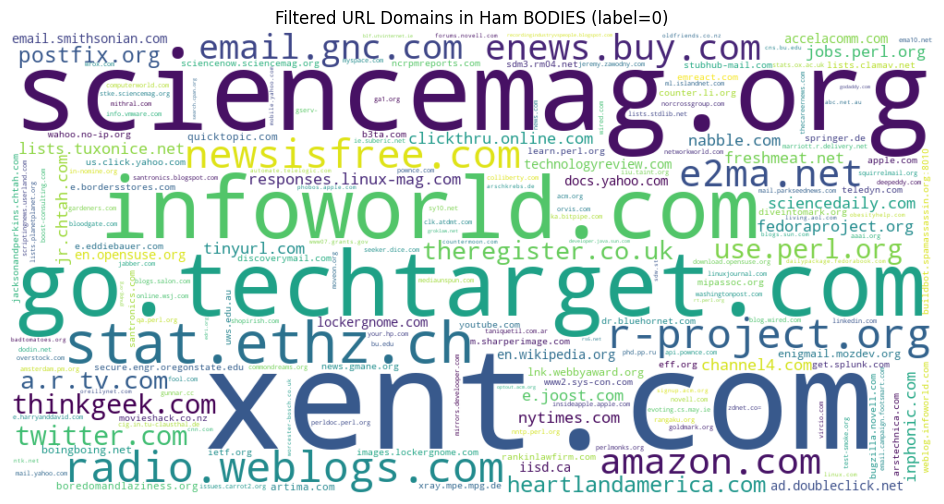

In [ ]:
import re
from urllib.parse import urlparse
from collections import Counter
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# --- 1) URL stopwords ---
URL_STOPWORDS = {
    'cgi.cnn.com','bbc.co.uk','news.bbc.co.uk','cnet.com','zdnet.com',
    'sourceforge.net','lists.sourceforge.net','mail.python.org','bugs.python.org',
    'python.org','redhat.com','apache.org','issues.apache.org',
    'groups.google.com','postini.com','internet.com','waikato.ac.nz',
    'freshrpms.net','slashdot.org','linux.ie',
    'opera.com','google.com',
    'list.scms.waikato.ac.nz','click.ecostemail.com'
}

# --- 2) URL regex ---
url_pattern = re.compile(r'(https?://[^\s)>\]\'"]+|www\.[^\s)>\]\'"]+)', re.IGNORECASE)

def extract_domains(text: str):
    """Return list of domains found in text."""
    if not isinstance(text, str) or not text:
        return []
    urls = url_pattern.findall(text)
    domains = []
    for u in urls:
        if not u.lower().startswith(('http://', 'https://')):
            u = 'http://' + u
        try:
            netloc = urlparse(u).netloc.lower()
        except Exception:
            continue
        if netloc.startswith('www.'):
            netloc = netloc[4:]
        if netloc and netloc not in ('localhost',):
            domains.append(netloc)
    return domains

def filter_url_stopwords(domains):
    """Remove domains that match any stopword substring."""
    return [d for d in domains if not any(sw in d for sw in URL_STOPWORDS)]

def remove_urls(text: str):
    """Strip URLs from text and tidy whitespace."""
    if not isinstance(text, str) or not text:
        return text if isinstance(text, str) else ""
    cleaned = url_pattern.sub(" ", text)
    # collapse multiple spaces and strip
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    return cleaned

# --- 3) Build new columns (subject/body domains + cleaned content) ---
# Ensure columns exist
for col in ['subject', 'body']:
    if col not in df.columns:
        df[col] = ""

# Domains
df['url_domains_subject'] = df['subject'].apply(extract_domains)
df['url_domains_body']    = df['body'].apply(extract_domains)

# Cleaned content (without URLs)
df['subject_no_urls'] = df['subject'].apply(remove_urls)
df['body_no_urls']    = df['body'].apply(remove_urls)

# --- 4) (Optional) Per-class domain frequencies, subject vs body ---
MIN_COUNT = 2

phish_counts_subject = Counter(d for lst in df.loc[df['label']==1, 'url_domains_subject'] for d in lst)
ham_counts_subject   = Counter(d for lst in df.loc[df['label']==0, 'url_domains_subject'] for d in lst)

phish_counts_body = Counter(d for lst in df.loc[df['label']==1, 'url_domains_body'] for d in lst)
ham_counts_body   = Counter(d for lst in df.loc[df['label']==0, 'url_domains_body'] for d in lst)

phish_freq_subject = {k:v for k,v in phish_counts_subject.items() if v >= MIN_COUNT}
ham_freq_subject   = {k:v for k,v in ham_counts_subject.items()   if v >= MIN_COUNT}

phish_freq_body = {k:v for k,v in phish_counts_body.items() if v >= MIN_COUNT}
ham_freq_body   = {k:v for k,v in ham_counts_body.items()   if v >= MIN_COUNT}

def to_top(dfreq, k=20):
    return (pd.DataFrame(list(dfreq.items()), columns=['Domain','Frequency'])
              .sort_values('Frequency', ascending=False).head(k).reset_index(drop=True))

top_phish_subject = to_top(phish_freq_subject)
top_ham_subject   = to_top(ham_freq_subject)
top_phish_body    = to_top(phish_freq_body)
top_ham_body      = to_top(ham_freq_body)

print("\nTop 20 Domains in Phishing Subjects:")
display(top_phish_subject)
print("\nTop 20 Domains in Ham Subjects:")
display(top_ham_subject)

print("\nTop 20 Domains in Phishing Bodies:")
display(top_phish_body)
print("\nTop 20 Domains in Ham Bodies:")
display(top_ham_body)

# --- 5) (Optional) WordClouds for subject/body separately ---
def plot_wc(freq_dict, title):
    if not freq_dict:
        print(f"[{title}] No domains found.")
        return
    wc = WordCloud(width=1000, height=500, background_color='white')
    wc = wc.generate_from_frequencies(freq_dict)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wc(phish_freq_subject, "URL Domains in Phishing SUBJECTS (label=1)")
plot_wc(ham_freq_subject,   "URL Domains in Ham SUBJECTS (label=0)")
plot_wc(phish_freq_body,    "URL Domains in Phishing BODIES (label=1)")
plot_wc(ham_freq_body,      "URL Domains in Ham BODIES (label=0)")


## body word cloud

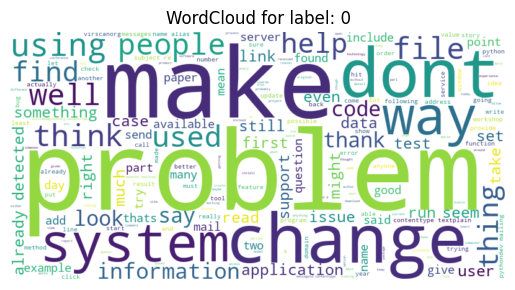

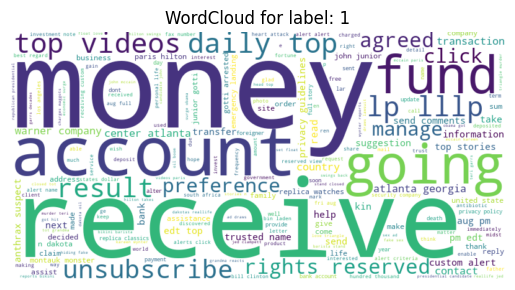

/opt/miniconda3/envs/dsa4263/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(
/opt/miniconda3/envs/dsa4263/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


group,0,1
rank,,
1,feb,top
2,dont,account
3,mailing,money
4,using,company
5,file,bank
6,data,name
7,information,receive
8,web,click
9,make,going


In [9]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

stopwords = set(STOPWORDS)

ceas_boilerplate = {
    # CEAS wrapper artifacts
    'submission', 'submissionid', 'added','sender','notes','total','list','wrote','message','university','settings',
    # CEAS virus campaign artifacts
    'virus',
    # CEAS news campaign artifacts
    'cnncom','cnn','news','network','cable','cable news','news network',
    # extremely generic non-informative tokens
    'email','us','one','time','now','please'
}
generic_fillers = {
    'new','use','may','im','go','see','know','work','need','want', 'will'
}

stopwords.update(ceas_boilerplate)
stopwords.update(generic_fillers)


# Ensure clean_body exists and is string
df['clean_body'] = df.get('clean_body', df.get('body', '')).fillna('').astype(str)

# --- WordClouds by label ---
for label in sorted(df['label'].dropna().unique()):
    text = " ".join(df.loc[df['label'] == label, 'clean_body'])
    wc = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=stopwords
    ).generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for label: {label}")
    plt.show()

# --- Top 20 words/phrases (unigram + bigram) for 0, 1 ---

def get_top_terms(text_series, n=20, stopwords=None, ngram_range=(1,2)):
    vec = CountVectorizer(
        stop_words=stopwords,
        ngram_range=ngram_range,
        lowercase=True,
        token_pattern=r'(?u)\b[a-zA-Z0-9]{2,}\b'  # tokens of length >=2 (letters/digits)
    )
    X = vec.fit_transform(text_series)
    terms = vec.get_feature_names_out()
    counts = X.sum(axis=0).A1
    out = (pd.DataFrame({'term': terms, 'count': counts})
             .sort_values('count', ascending=False)
             .head(n)
             .reset_index(drop=True))
    return out

groups = {
    '0':   df.loc[df['label'] == 0, 'clean_body'],
    '1':   df.loc[df['label'] == 1, 'clean_body'],
}

frames = []
for gname, texts in groups.items():
    top = get_top_terms(texts, n=20, stopwords=list(stopwords), ngram_range=(1,2))
    top.insert(0, 'group', gname)
    top['rank'] = top['count'].rank(method='first', ascending=False).astype(int)
    frames.append(top)

top20_table = pd.concat(frames, ignore_index=True)[['group','rank','term','count']]

display(top20_table.pivot(index='rank', columns='group', values='term'))


In [20]:
df.head()

,sender,receiver,date,subject,body,urls,label,clean_body,url_domains,url_domains_filtered,...,alpha_count,digit_count,special_count,upper_ratio,url_domains_subject,url_domains_body,url_domains_subject_filtered,url_domains_body_filtered,subject_no_urls,body_no_urls
0,MR. JAMES NGOLA. <james_ngola2002@maktoob.com>,webmaster@aclweb.org,2002-10-31 02:38:20+00:00,URGENT BUSINESS ASSISTANCE AND PARTNERSHIP,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...,0,1,frommr james ngola confidential tel email jame...,[],[],...,2658,35,84,0.992476,[],[],[],[],URGENT BUSINESS ASSISTANCE AND PARTNERSHIP,FROM:MR. JAMES NGOLA. CONFIDENTIAL TEL: 233-27...
1,Mr. Ben Suleman <bensul2004nng@spinfinder.com>,R@M,2002-10-31 05:10:00+00:00,URGENT ASSISTANCE /RELATIONSHIP (P),"Dear Friend,\n\nI am Mr. Ben Suleman a custom ...",0,1,dear friend i am mr ben suleman a custom offic...,[],[],...,2587,46,66,0.042907,[],[],[],[],URGENT ASSISTANCE /RELATIONSHIP (P),"Dear Friend, I am Mr. Ben Suleman a custom off..."
2,PRINCE OBONG ELEME <obong_715@epatra.com>,webmaster@aclweb.org,2002-10-31 22:17:55+01:00,GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,0,1,from his royal majesty hrm crown ruler of elem...,[],[],...,2576,24,73,0.067935,[],[],[],[],GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3,PRINCE OBONG ELEME <obong_715@epatra.com>,webmaster@aclweb.org,2002-10-31 22:44:20+00:00,GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,0,1,from his royal majesty hrm crown ruler of elem...,[],[],...,2576,24,73,0.067935,[],[],[],[],GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4,Maryam Abacha <m_abacha03@www.com>,R@M,2002-11-01 01:45:04+01:00,I Need Your Assistance.,"Dear sir, \n \nIt is with a heart full of hope...",0,1,dear sir it is with a heart full of hope that ...,[],[],...,3222,13,81,0.027312,[],[],[],[],I Need Your Assistance.,"Dear sir, It is with a heart full of hope that..."


In [10]:
# We already have: top20_table with columns ['group','rank','term','count']

# --- Separate Top-20 Tables per group (with term + count) ---
top_0   = (top20_table[top20_table['group']=='0'][['rank','term','count']]
           .set_index('rank').sort_index())
top_1   = (top20_table[top20_table['group']=='1'][['rank','term','count']]
           .set_index('rank').sort_index())

# --- Single Combined Table (side-by-side, aligned by rank) ---
combined = (
    top_0.rename(columns={'term':'ham_term','count':'ham_count'})
    .join(top_1.rename(columns={'term':'phish_term','count':'phish_count'}), how='outer')
    .sort_index()
)

print("\nTop 20 Terms — Combined (by rank):")
display(combined)



Top 20 Terms — Combined (by rank):


,ham_term,ham_count,phish_term,phish_count
rank,,,,
1,feb,8729,top,15769
2,dont,8372,account,12711
3,mailing,8075,money,12219
4,using,7886,company,8720
5,file,7625,bank,8515
6,data,7447,name,8415
7,information,7436,receive,7843
8,web,6838,click,7120
9,make,6738,going,7057


## Text Length & Structure
Understanding differences in subject/body length helps flag unusually short or long phishing messages.

subject_len            body_len              body_word_count            
           median       mean   median         mean          median        mean
label                                                                         
0            43.0  45.885140   1197.0  2446.552850           179.0  337.604860
1            27.0  31.482633    344.0  1383.429194            55.0  152.720011

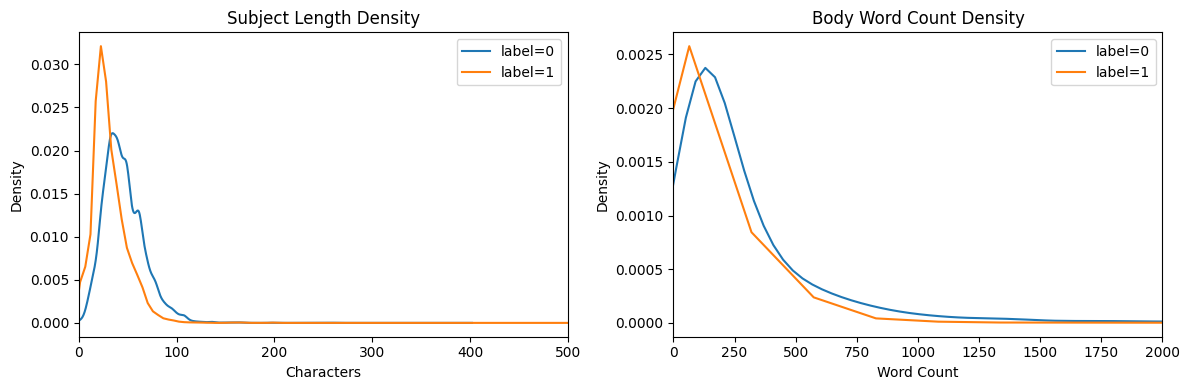

In [11]:
# Fill missing values directly (non-destructive if you prefer .fillna() with inplace=False)
df['subject'] = df['subject'].fillna('')
df['body'] = df['body'].fillna('')

# Compute length features directly in the main df
df['subject_len'] = df['subject'].str.len()
df['body_len'] = df['body'].str.len()
df['body_word_count'] = df['body'].str.split().str.len()

# Display summary stats by label
display(
    df.groupby('label')[['subject_len', 'body_len', 'body_word_count']]
      .agg(['median', 'mean'])
)

# Plot KDEs
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for label_value, group in df.groupby('label'):
    group['subject_len'].plot(kind='kde', ax=axes[0], label=f'label={label_value}')
    group['body_word_count'].plot(kind='kde', ax=axes[1], label=f'label={label_value}')

axes[0].set_title('Subject Length Density')
axes[0].set_xlabel('Characters')
axes[1].set_title('Body Word Count Density')
axes[1].set_xlabel('Word Count')

for ax in axes:
    ax.legend()
axes[0].set_xlim(0, 500)
axes[1].set_xlim(0, 2000)
plt.tight_layout()
plt.show()


Phishing emails exhibit significantly shorter subjects and bodies than legitimate emails, validating the hypothesis that message brevity is a distinguishing characteristic of phishing attempts.

## Puncutation / Capitalisation / Special Char

In [12]:
df['body'] = df['body'].fillna('')
df['exclaim_count']  = df['body'].str.count('!')
df['question_count'] = df['body'].str.count(r'\?')
df['upper_count']    = df['body'].str.count(r'[A-Z]')
df['alpha_count']    = df['body'].str.count(r'[A-Za-z]')
df['digit_count']    = df['body'].str.count(r'\d')
df['special_count']  = df['body'].str.count(r'[^A-Za-z0-9\s]')
df['upper_ratio'] = df['upper_count'] / df['alpha_count'].replace(0, np.nan)

# Summary table
cols = ['exclaim_count','question_count','digit_count','special_count','upper_ratio']
display(
    df.groupby('label')[cols]
      .agg(['median','mean'])
      .round(3)
)

exclaim_count        question_count        digit_count          \
             median   mean         median   mean      median    mean   
label                                                                  
0               0.0  1.401            1.0  2.272        26.0  94.353   
1               0.0  1.063            0.0  1.730         5.0  70.973   

      special_count          upper_ratio         
             median     mean      median   mean  
label                                            
0             117.0  254.273       0.057  0.071  
1              15.0  126.918       0.055  0.109

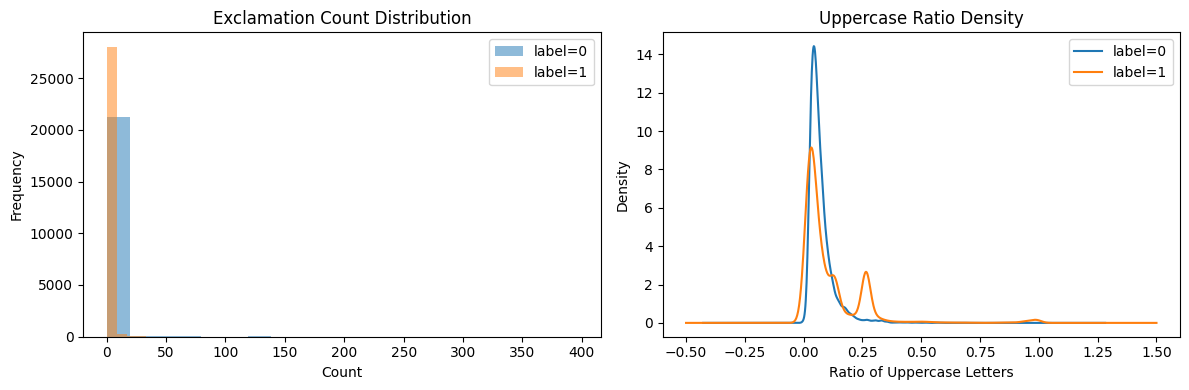

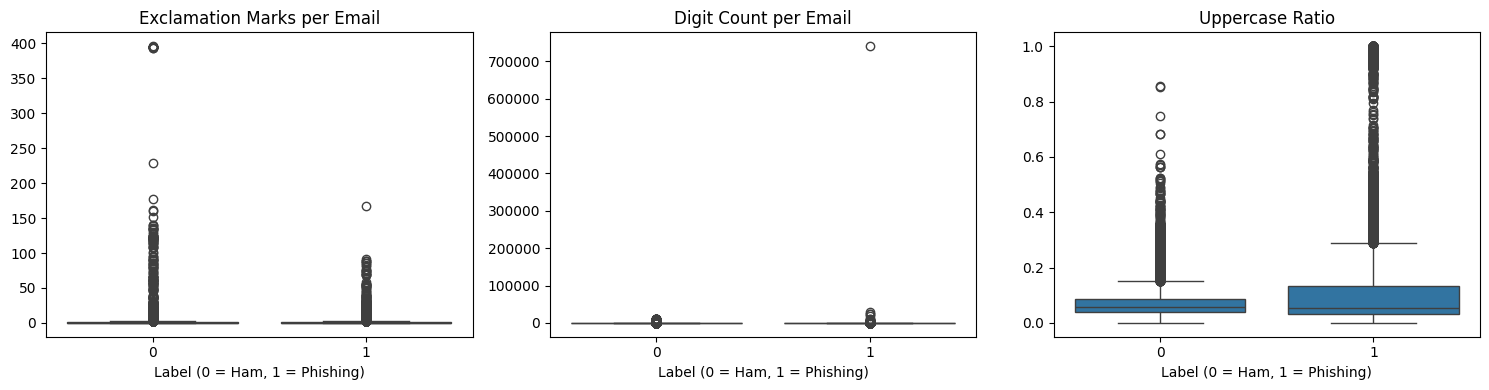

In [13]:
# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for label_value, g in df.groupby('label'):
    g['exclaim_count'].plot(kind='hist', ax=axes[0], alpha=0.5, bins=20, label=f'label={label_value}')
    g['upper_ratio'].plot(kind='kde', ax=axes[1], label=f'label={label_value}')
axes[0].set_title('Exclamation Count Distribution'); axes[0].set_xlabel('Count')
axes[1].set_title('Uppercase Ratio Density');       axes[1].set_xlabel('Ratio of Uppercase Letters')
for ax in axes: ax.legend()
plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.boxplot(x='label', y='exclaim_count', data=df, ax=axes[0]); axes[0].set_title('Exclamation Marks per Email')
sns.boxplot(x='label', y='digit_count',   data=df, ax=axes[1]); axes[1].set_title('Digit Count per Email')
sns.boxplot(x='label', y='upper_ratio',   data=df, ax=axes[2]); axes[2].set_title('Uppercase Ratio')
for ax in axes:
    ax.set_xlabel('Label (0 = Ham, 1 = Phishing)'); ax.set_ylabel('')
plt.tight_layout(); plt.show()


In [14]:
from scipy.stats import mannwhitneyu

features = ['exclaim_count', 'digit_count', 'special_count', 'upper_ratio']
for col in features:
    stat, p = mannwhitneyu(df.loc[df.label==0, col],
                           df.loc[df.label==1, col],
                           alternative='two-sided')
    print(f"{col}: U={stat:.2f}, p-value={p:.4g}")

exclaim_count: U=270975578.50, p-value=6.991e-136
digit_count: U=425537180.00, p-value=0
special_count: U=485205820.50, p-value=0
upper_ratio: U=305173876.50, p-value=0.6047


- **Strong evidence** that legitimate and phishing emails differ in **exclamation, digit, and special-character usage** (p < 0.001).  
- **No significant difference** in uppercase ratio despite visual variance; capitalization alone is not a reliable discriminator.  
- Overall, phishing messages are **simpler and less formatted**, while ham emails are **longer and more structured** with richer punctuation and metadata.

**Conclusion:**  
Phishing and ham emails exhibit statistically distinct stylistic patterns—particularly in punctuation and numeric content—supporting the hypothesis that phishing relies on brevity and emotional emphasis, whereas legitimate messages are content-dense and formally formatted.

In [15]:
df[['label','exclaim_count','upper_ratio','digit_count']].corr()['label']

label            1.000000
exclaim_count   -0.020339
upper_ratio      0.163877
digit_count     -0.003464
Name: label, dtype: float64

<Axes: >

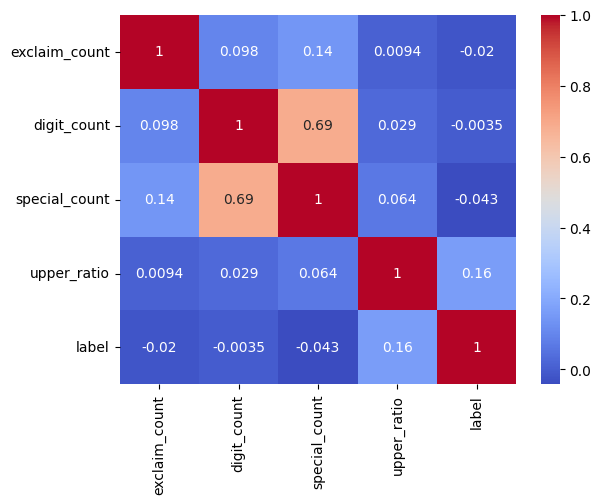

In [16]:
sns.heatmap(df[['exclaim_count','digit_count','special_count','upper_ratio','label']].corr(),
            annot=True, cmap='coolwarm')


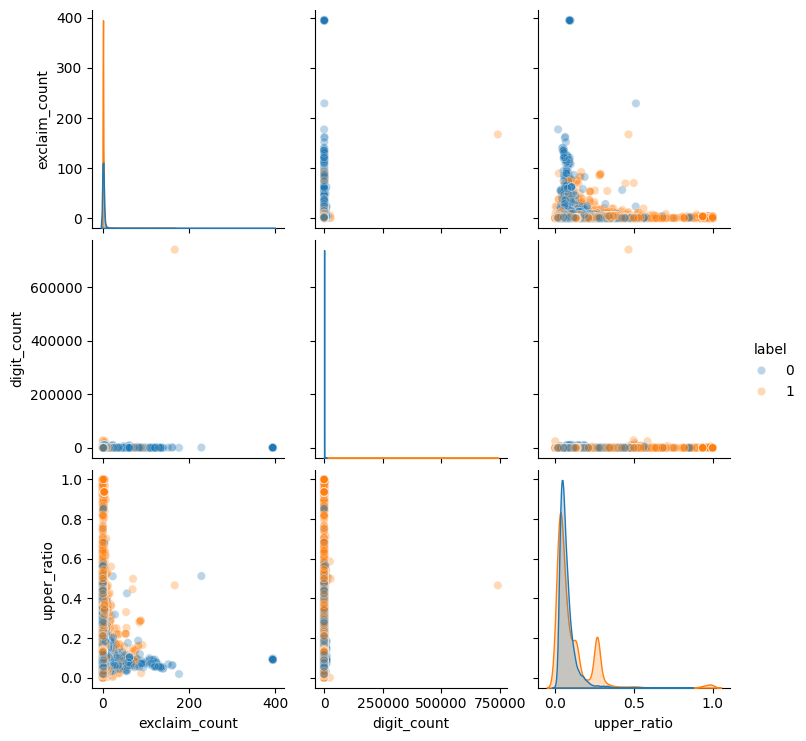

In [17]:
sns.pairplot(df, vars=['exclaim_count','digit_count','upper_ratio'], hue='label', plot_kws={'alpha':0.3})